In [1]:
import quantus

quantus.helpers.constants.available_categories()


/home/student/anaconda3/envs/xai-chan/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['Faithfulness',
 'Robustness',
 'Localisation',
 'Complexity',
 'Randomisation',
 'Axiomatic']

In [2]:
quantus.helpers.constants.available_metrics()


{'Faithfulness': ['Faithfulness Correlation',
  'Faithfulness Estimate',
  'Pixel-Flipping',
  'Region Segmentation',
  'Monotonicity-Arya',
  'Monotonicity-Nguyen',
  'Selectivity',
  'SensitivityN',
  'IROF',
  'ROAD',
  'Infidelity',
  'Sufficiency'],
 'Robustness': ['Continuity Test',
  'Local Lipschitz Estimate',
  'Max-Sensitivity',
  'Avg-Sensitivity',
  'Consistency',
  'Relative Input Stability',
  'Relative Output Stability',
  'Relative Representation Stability'],
 'Localisation': ['Pointing Game',
  'Top-K Intersection',
  'Relevance Mass Accuracy',
  'Relevance Rank Accuracy',
  'Attribution Localisation ',
  'AUC',
  'Focus'],
 'Complexity': ['Sparseness', 'Complexity', 'Effective Complexity'],
 'Randomisation': ['Model Parameter Randomisation', 'Random Logit'],
 'Axiomatic': ['Completeness', 'NonSensitivity', 'InputInvariance']}

In [47]:
from utils.models import ResNet_Model
import torch
weights_path = "/home/student/Desktop/31171109-donotdelete/xai-chan/result/imagenet/_Fold_2_5_400X_BreakHis_FT_60_resnet50_imagenet_/_37_96.07250755287009_95.06917631917632_0.9614846110343933.pth"  # TODO: Provide the model path
# def force_cudnn_initialization(device):
#     s = 32
#     torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=device), torch.zeros(s, s, s, s, device=device))
device = torch.device('cuda:0')
# force_cudnn_initialization(device=device)

# Load model
version = 50
downstream_task_model = ResNet_Model(version=version).to(device)
downstream_task_model.load_state_dict(torch.load(weights_path, map_location=device))
downstream_task_model.eval()

ResNet_Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

In [10]:
import os
import numpy as np
import PIL.Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as t
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CustomDataset(Dataset):
    def __init__(self, benign_path, malignant_path, transform=None, augmentation=None):
        # Store all the image paths and associated labels (0 for benign, 1 for malignant)
        self.image_paths = [os.path.join(benign_path, fname) for fname in os.listdir(benign_path)] + \
                           [os.path.join(malignant_path, fname) for fname in os.listdir(malignant_path)]
        self.labels = [0] * len(os.listdir(benign_path)) + [1] * len(os.listdir(malignant_path))
        
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Load image
        img = PIL.Image.open(img_path)

        # Convert image to numpy array
        img_np = np.array(img)

        # Apply transformations
        if self.augmentation:
            augmented = self.augmentation(image=img_np)
            img_np = augmented["image"]

        if self.transform:
            img = self.transform(img_np)
        
        return img, label

# Example usage:

# Replace with your image paths

BENIGN_PATH = "/home/student/Desktop/31171109-donotdelete/xai-chan/explanation/val_10/SOB_B_F_14-21998EF/400X"
MALIGNANT_PATH = "/home/student/Desktop/31171109-donotdelete/xai-chan/explanation/val_10/SOB_M_LC_14-16196/400X"

# Define transformations
transform = t.Compose([
    t.ToPILImage(), 
    t.Resize((341, 341)),
    t.ToTensor()
])

augmentation_03 = A.Compose([
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, always_apply=False, p=0.3),
    A.Flip(p=0.3),
    A.Rotate(p=0.3),
    A.Affine(translate_percent=0.05, p=0.3),
    A.Resize(height=341, width=341, p=1),
    A.RandomCrop(height=252, width=252, p=1),
    ToTensorV2()
])

dataset = CustomDataset(BENIGN_PATH, MALIGNANT_PATH, transform=transform, augmentation=augmentation_03)


In [39]:
BATCH_SIZE = 10
SHUFFLE = False

data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

# Example to get a batch of data
for x_batch, y_batch in data_loader:
    # x_batch contains images, y_batch contains labels
    # Generate Integrated Gradients attributions of the first batch of the test set.

    pass
print(x_batch,y_batch)
x_batch, y_batch = x_batch.to(device),  y_batch.to(device)



tensor([[[[0.9961, 0.9961, 0.9961,  ..., 0.9020, 0.9098, 0.9098],
          [0.9882, 0.9922, 0.9922,  ..., 0.8902, 0.9020, 0.9137],
          [0.9725, 0.9765, 0.9843,  ..., 0.8863, 0.8980, 0.9137],
          ...,
          [0.8157, 0.8588, 0.8980,  ..., 0.9529, 0.9216, 0.8980],
          [0.8196, 0.8588, 0.8863,  ..., 0.9490, 0.9216, 0.9020],
          [0.8078, 0.8392, 0.8588,  ..., 0.9490, 0.9216, 0.8980]],

         [[0.8745, 0.8824, 0.8863,  ..., 0.8039, 0.8039, 0.8000],
          [0.8353, 0.8431, 0.8471,  ..., 0.7922, 0.7961, 0.8039],
          [0.7804, 0.7843, 0.7882,  ..., 0.7882, 0.8000, 0.8157],
          ...,
          [0.3098, 0.3529, 0.3922,  ..., 0.5608, 0.5059, 0.4627],
          [0.3255, 0.3529, 0.3804,  ..., 0.5608, 0.5137, 0.4784],
          [0.3176, 0.3373, 0.3529,  ..., 0.5647, 0.5216, 0.4863]],

         [[0.9569, 0.9608, 0.9608,  ..., 0.9020, 0.9020, 0.8941],
          [0.9451, 0.9529, 0.9569,  ..., 0.8863, 0.8980, 0.9020],
          [0.9255, 0.9373, 0.9412,  ..., 0

In [30]:
import zennit
# The canonizer can be a zennit.canonizers.Canonizer subclass or None.
canonizer = None 

# The composite can be a zennit.core.Composite subclass, a string mapping to a composite, or None.
composite = None

# The attributor can be any zennit.attribution.Attributor subclass.
attributor = zennit.attribution.IntegratedGradients 

# In case both captum and zennit are installed, this kwarg also needs to be set to "zennit"
xai_lib = "zennit"

In [45]:
import torch
torch.cuda.empty_cache()
# import os

# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:1000'

In [40]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(
    downstream_task_model, 
    x_batch, 
    y_batch, 
    canonizer=canonizer,
    composite=composite,
    attributor=attributor,
)

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch_tmp, y_batch_tmp = x_batch.cpu().numpy(), y_batch.cpu().numpy()

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, a_batch]]

OutOfMemoryError: CUDA out of memory. Tried to allocate 36.00 MiB (GPU 0; 15.88 GiB total capacity; 7.29 GiB already allocated; 42.00 MiB free; 7.34 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

NameError: name 'x_batch_tmp' is not defined

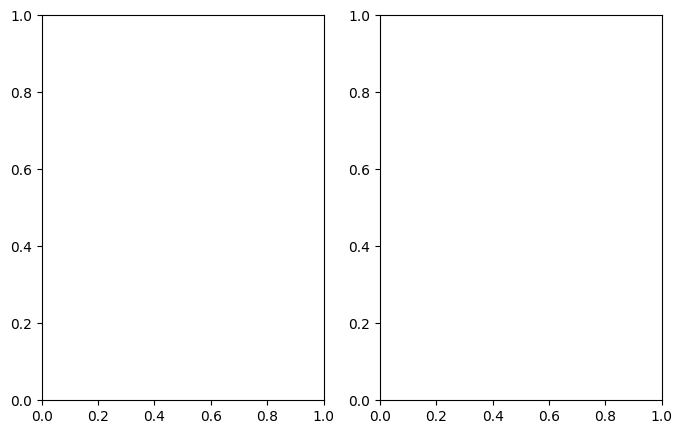

In [23]:
import sys
import os
import cv2
import json
import random
from PIL import Image
import pathlib
import numpy as np
import pandas as pd
import quantus
import torch
import torchvision
from captum.attr import *
import matplotlib.pyplot as plt

import zennit
index = random.randint(0, len(x_batch)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch_tmp[index], mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch_tmp[index].item()}")
exp = axes[1].imshow(a_batch[index].reshape(224, 224), cmap="seismic") 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show();

In [13]:
quantus.AUC(
)(model=downstream_task_model, 
   x_batch=x_batch.cuda(),
   y_batch=y_batch.cuda(),
   a_batch=None,
   explain_func=quantus.explain, 
  explain_func_kwargs={"method": "Saliency"},
  device=device)

Warnings and information:
 (1) The AUC metric is likely to be sensitive to the choice of ground truth mask i.e., the 's_batch' input as well as if absolute values 'abs' are taken of the attributions .  
 (2) If attributions are normalised or their absolute values are taken it may destroy or skew information in the explanation and as a result, affect the overall evaluation outcome.
 (3) Make sure to validate the choices for hyperparameters of the metric (by calling .get_params of the metric instance).
 (4) For further information, see original publication: Fawcett, Tom. 'An introduction to ROC analysis' Pattern Recognition Letters Vol 27, Issue 8, (2006).
 (5) To disable these warnings set 'disable_warnings' = True when initialising the metric.



/home/student/anaconda3/envs/xai-chan/lib/python3.9/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
quantus.AUC(
)(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   explain_func=quantus.explain, 
  explain_func_kwargs={"method": "Saliency"},
  device=device)